In [17]:
# Complete Speech Emotion Recognition Pipeline (Single Cell)
# No per‐epoch prints of loss/accuracy — training runs silently.

# 0. Setup & Imports
import os, warnings, timeit, multiprocessing as mp
import numpy as np
import pandas as pd
import librosa, librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from joblib import Parallel, delayed

import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Dropout,
    Flatten, Dense
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)

import pickle

warnings.simplefilter("ignore")
print("CPUs available:", mp.cpu_count())


CPUs available: 4


In [18]:
# 1. Paths to audio datasets
ravdess_path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
crema_path  = "/kaggle/input/cremad/AudioWAV/"
tess_path   = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
savee_path  = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"


In [19]:
# 2. Load & parse each dataset
def load_dataset(base_path, parser):
    records = []
    for entry in os.listdir(base_path):
        records.extend(parser(base_path, entry))
    return pd.DataFrame(records)

def parse_ravdess(base, actor):
    recs = []
    dirpath = os.path.join(base, actor)
    for fname in os.listdir(dirpath):
        code = fname.split('-')[2]
        label = {
            '01':'neutral','02':'calm','03':'happy','04':'sad',
            '05':'angry','06':'fearful','07':'disgust','08':'surprised'
        }[code].lower()
        recs.append({'Path': os.path.join(dirpath, fname), 'Emotion': label})
    return recs

ravdess_df = load_dataset(ravdess_path, parse_ravdess)

def parse_crema(base, fname):
    lab = fname.split('_')[2]
    label = {'SAD':'sad','ANG':'angry','DIS':'disgust',
             'FEA':'fearful','HAP':'happy','NEU':'neutral'}.get(lab, 'unknown').lower()
    return [{'Path': os.path.join(base, fname), 'Emotion': label}]

crema_df = load_dataset(crema_path, parse_crema)

def parse_tess(base, actor):
    recs = []
    dirpath = os.path.join(base, actor)
    for fname in os.listdir(dirpath):
        lab = fname.split('_')[2].lower()
        label = 'surprised' if lab=='ps' else lab
        recs.append({'Path': os.path.join(dirpath, fname), 'Emotion': label})
    return recs

tess_df = load_dataset(tess_path, parse_tess)

def parse_savee(base, fname):
    ele = fname.split('_')[1][:-6]
    label = {'a':'angry','d':'disgust','f':'fearful',
             'h':'happy','n':'neutral','sa':'sad'}.get(ele, 'surprised')
    return [{'Path': os.path.join(base, fname), 'Emotion': label}]

savee_df = load_dataset(savee_path, parse_savee)

Total samples: 12162


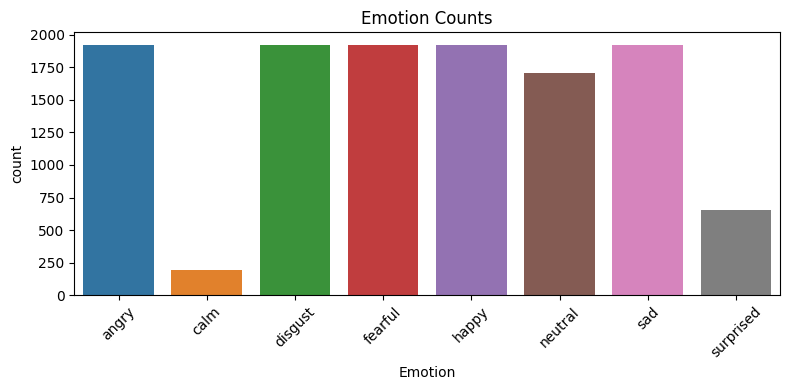

In [20]:
# 3. Combine and clean labels
data_path = pd.concat([ravdess_df, crema_df, tess_df, savee_df], ignore_index=True)
data_path['Emotion'] = data_path['Emotion'].str.replace(r"\.wav$", "", regex=True)
data_path['Emotion'] = data_path['Emotion'].replace({
    'fear':'fearful',
    'ps':'surprised',
    'pleasantsurprise':'surprised'
})
data_path = shuffle(data_path, random_state=42).reset_index(drop=True)

print("Total samples:", len(data_path))
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=data_path, order=sorted(data_path.Emotion.unique()))
plt.title("Emotion Counts"); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


In [21]:
# 4. Augmentation functions
def add_noise(x): return x + 0.035*np.random.uniform()*np.amax(x)*np.random.normal(size=x.shape)
def stretch(x, rate=0.8): return librosa.effects.time_stretch(y=x, rate=rate)
def shift(x): return np.roll(x, int(np.random.uniform(-5,5)*1000))
def pitch(x, sr, n_steps=0.7): return librosa.effects.pitch_shift(y=x, sr=sr, n_steps=n_steps)


In [22]:
# 5. Fixed-length feature extractor
n_mfcc, max_frames = 40, 100
def pad_truncate(feat, max_len):
    return (np.pad(feat, ((0,0),(0,max_len-feat.shape[1])), mode='constant')
            if feat.shape[1]<max_len else feat[:,:max_len])

def extract_features_fixed(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = pad_truncate(mfcc, max_frames)
    mfcc = (mfcc - mfcc.mean())/(mfcc.std()+1e-6)
    z = pad_truncate(librosa.feature.zero_crossing_rate(y=y), max_frames)
    r = pad_truncate(librosa.feature.rms(y=y), max_frames)
    stacked = np.vstack((mfcc, z, r))
    return stacked.flatten()

def get_features(path):
    y, sr = librosa.load(path, duration=2.5, offset=0.6)
    out = [extract_features_fixed(y, sr)]
    for fn in (add_noise, lambda x: stretch(x,0.8), shift, lambda x: pitch(x, sr, 0.7)):
        out.append(extract_features_fixed(fn(y), sr))
    return np.stack(out, axis=0)

In [23]:
# 6. Parallel feature computation
start = timeit.default_timer()
results = Parallel(n_jobs=-1)(delayed(get_features)(p) for p in data_path.Path)
print("Feature extraction time:", timeit.default_timer() - start)

Feature extraction time: 695.613156853


In [24]:
# 7. Assemble X, Y
X, Y = [], []
for feats, emo in zip(results, data_path.Emotion):
    for vec in feats:
        X.append(vec); Y.append(emo)
X = np.vstack(X); Y = np.array(Y)
print("Feature array shape:", X.shape)

Feature array shape: (60810, 4200)


In [25]:
# 8. Preprocess & split
scaler = StandardScaler().fit(X); X_scaled = scaler.transform(X)
encoder = OneHotEncoder(sparse=False).fit(Y.reshape(-1,1))
Y_enc = encoder.transform(Y.reshape(-1,1))

x_tr, x_te, y_tr, y_te = train_test_split(
    X_scaled, Y_enc, test_size=0.2, random_state=42, stratify=Y
)
x_tr_cnn = x_tr[..., np.newaxis]; x_te_cnn = x_te[..., np.newaxis]
print("Train/Test shapes:", x_tr_cnn.shape, x_te_cnn.shape)

Train/Test shapes: (48648, 4200, 1) (12162, 4200, 1)


In [27]:
from tensorflow.keras.callbacks import Callback

# 9. Epoch-detail logger callback
class EpochDetailLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        l = logs or {}
        print(f"Epoch {epoch+1} -> loss: {l['loss']:.4f}, acc: {l['accuracy']:.4f}, "
              f"val_loss: {l['val_loss']:.4f}, val_acc: {l['val_accuracy']:.4f}")


In [32]:
# 10. Model & train
from tensorflow.keras.callbacks import Callback


model = Sequential([
    Conv1D(512, 5, padding='same', activation='relu', input_shape=x_tr_cnn.shape[1:]),
    BatchNormalization(), MaxPooling1D(5, 2, padding='same'),
    
    Conv1D(512, 5, padding='same', activation='relu'), BatchNormalization(),
    MaxPooling1D(5, 2, padding='same'), Dropout(0.2),
    
    Conv1D(256, 5, padding='same', activation='relu'), BatchNormalization(),
    MaxPooling1D(5, 2, padding='same'),
    
    Conv1D(256, 3, padding='same', activation='relu'), BatchNormalization(),
    MaxPooling1D(5, 2, padding='same'), Dropout(0.2),
    
    Conv1D(128, 3, padding='same', activation='relu'), BatchNormalization(),
    MaxPooling1D(3, 2, padding='same'), Dropout(0.2),
    
    Flatten(),
    Dense(512, activation='relu'), BatchNormalization(),
    Dense(Y_enc.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


cb = [
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3),
    EpochLogger()
]

# Train
history = model.fit(
    x_tr_cnn, y_tr,
    validation_data=(x_te_cnn, y_te),
    epochs=50, batch_size=64,
    callbacks=cb,
    verbose=0
)


I0000 00:00:1745941436.400699     133 service.cc:148] XLA service 0x7a199801a840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745941436.401282     133 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745941437.045125     133 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745941450.126792     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1 -> loss: 1.0412, acc: 0.6166, val_loss: 0.9124, val_acc: 0.6573
Epoch 2 -> loss: 0.7427, acc: 0.7237, val_loss: 0.7433, val_acc: 0.7253
Epoch 3 -> loss: 0.5568, acc: 0.7944, val_loss: 0.7049, val_acc: 0.7427
Epoch 4 -> loss: 0.4064, acc: 0.8509, val_loss: 0.5463, val_acc: 0.8018
Epoch 5 -> loss: 0.2768, acc: 0.9006, val_loss: 0.4719, val_acc: 0.8380
Epoch 6 -> loss: 0.1970, acc: 0.9310, val_loss: 0.5633, val_acc: 0.8171
Epoch 7 -> loss: 0.1729, acc: 0.9390, val_loss: 0.4045, val_acc: 0.8656
Epoch 8 -> loss: 0.1006, acc: 0.9658, val_loss: 0.4551, val_acc: 0.8648
Epoch 9 -> loss: 0.1139, acc: 0.9608, val_loss: 0.4189, val_acc: 0.8689
Epoch 10 -> loss: 0.0982, acc: 0.9660, val_loss: 0.4422, val_acc: 0.8664
Epoch 11 -> loss: 0.0585, acc: 0.9806, val_loss: 0.3871, val_acc: 0.8815
Epoch 12 -> loss: 0.0575, acc: 0.9803, val_loss: 0.4143, val_acc: 0.8824
Epoch 13 -> loss: 0.0758, acc: 0.9747, val_loss: 0.6093, val_acc: 0.8393
Epoch 14 -> loss: 0.1081, acc: 0.9635, val_loss: 0.3519, val

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1. Evaluate on training and validation sets
train_loss, train_acc = model.evaluate(x_tr_cnn, y_tr, verbose=0)
val_loss, val_acc = model.evaluate(x_te_cnn, y_te, verbose=0)

# 2. Predict on test set
y_pred_probs = model.predict(x_test_cnn)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 3. Evaluate on test set
test_loss, test_acc = model.evaluate(x_te_cnn, y_te, verbose=0)

# 4. Print accuracies
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# 5. Confusion Matrix and Classification Report
cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred)

print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(cr)


NameError: name 'x_test_cnn' is not defined